In [212]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, GlobalAveragePooling1D, LSTM, Reshape
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [213]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [214]:
train_data = pd.read_csv('text_emotion.csv')

In [215]:
train_data.head()

,sentiment,content
0,joy,[ On days when I feel close to my partner and ...
1,fear,Every time I imagine that someone I love or I ...
2,anger_disgust,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,anger_disgust,At a gathering I found myself involuntarily si...


In [216]:
train_data['target'] = train_data.sentiment.astype('category').cat.codes

In [217]:
train_data['num_words'] = train_data.content.apply(lambda x : len(x.split()) if type(x) == str else 0)

In [218]:
bins=[0,50,75, np.inf]
train_data['bins']=pd.cut(train_data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [219]:
word_distribution = train_data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [220]:
word_distribution.head()

,bins,counts
0,0-100,7630
1,100-300,22
2,300-500,0
3,500-800,0
4,>800,0


Text(0.5, 1.0, 'Word distribution per bin')

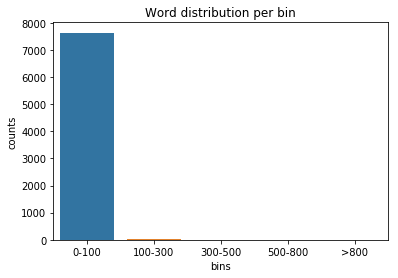

In [221]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [222]:
num_class = len(np.unique(train_data.sentiment.values))
y = train_data['target'].values
num_class

5

In [223]:
MAX_LENGTH = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.content.values)
post_seq = tokenizer.texts_to_sequences(train_data.content.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)
y_train

array([3, 1, 1, ..., 2, 2, 1], dtype=int8)

In [225]:
vocab_size = len(tokenizer.word_index) + 1

In [226]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

# x = Flatten()(embedding_layer)
x = LSTM(32, input_shape=(32, 32))(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=128, y=to_categorical(y_train), verbose=1, validation_split=0.05, 
          shuffle=True, epochs=8, callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 300, 128)          1171712   
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 165       
Total params: 1,193,541
Trainable params: 1,193,541
Non-trainable params: 0
_________________________________________________________________
Train on 6905 samples, validate on 364 samples
Epoch 1/8
6905/6905 [==============================] - 27s 4ms/step - loss: 1.5339 - 

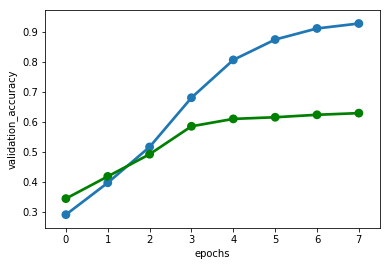

In [227]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [228]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.577023498694517

In [229]:
y_test

array([3, 4, 4, 2, 4, 2, 4, 1, 1, 1, 3, 4, 4, 0, 2, 3, 1, 0, 4, 0, 4, 4,
       3, 0, 1, 3, 3, 0, 0, 1, 1, 0, 0, 0, 4, 4, 4, 3, 0, 3, 3, 4, 4, 0,
       4, 3, 1, 2, 2, 4, 4, 4, 0, 4, 3, 3, 4, 2, 0, 1, 4, 1, 3, 0, 0, 2,
       4, 3, 0, 0, 1, 4, 1, 1, 1, 0, 4, 0, 0, 0, 3, 4, 4, 0, 0, 2, 1, 0,
       0, 3, 3, 2, 4, 3, 4, 0, 0, 1, 1, 4, 2, 3, 4, 4, 0, 4, 1, 2, 0, 4,
       0, 3, 0, 0, 3, 3, 4, 1, 0, 3, 3, 0, 1, 4, 4, 2, 4, 2, 2, 2, 4, 4,
       2, 0, 4, 0, 4, 4, 2, 4, 4, 2, 0, 0, 4, 0, 4, 1, 1, 1, 0, 2, 0, 0,
       4, 1, 4, 0, 0, 2, 1, 1, 3, 3, 0, 0, 2, 1, 0, 1, 2, 3, 4, 4, 4, 4,
       2, 4, 4, 4, 0, 0, 1, 3, 0, 4, 0, 4, 4, 2, 3, 3, 4, 4, 4, 2, 2, 4,
       1, 3, 1, 0, 2, 4, 0, 0, 0, 4, 3, 3, 0, 4, 3, 4, 3, 0, 0, 2, 2, 0,
       4, 0, 3, 0, 4, 2, 4, 1, 4, 4, 2, 0, 4, 0, 2, 0, 3, 2, 3, 0, 4, 1,
       3, 3, 3, 0, 0, 4, 2, 0, 2, 4, 0, 2, 2, 1, 3, 3, 4, 4, 0, 1, 0, 4,
       4, 3, 0, 0, 4, 0, 4, 1, 1, 2, 2, 1, 4, 4, 2, 0, 4, 0, 4, 1, 0, 2,
       4, 4, 0, 0, 0, 2, 0, 0, 0, 0, 3, 4, 0, 2, 1,

In [230]:
predicted

array([3, 4, 0, 1, 0, 2, 1, 4, 1, 3, 0, 4, 4, 0, 2, 3, 4, 0, 4, 3, 4, 4,
       4, 4, 2, 3, 3, 4, 3, 1, 0, 4, 3, 0, 4, 4, 4, 1, 4, 4, 3, 4, 4, 0,
       3, 3, 1, 0, 2, 1, 4, 4, 0, 0, 3, 3, 2, 3, 1, 1, 0, 1, 1, 0, 0, 0,
       4, 3, 0, 0, 0, 4, 1, 0, 1, 4, 0, 4, 3, 4, 2, 4, 4, 0, 0, 4, 1, 0,
       4, 0, 3, 4, 4, 3, 4, 0, 0, 1, 1, 2, 2, 1, 4, 3, 0, 0, 2, 2, 4, 4,
       1, 3, 1, 0, 0, 3, 3, 0, 0, 3, 3, 4, 0, 4, 0, 4, 4, 2, 4, 1, 0, 4,
       4, 0, 3, 0, 4, 4, 2, 4, 4, 2, 0, 4, 4, 0, 3, 0, 0, 0, 3, 2, 4, 0,
       0, 4, 0, 3, 4, 2, 1, 1, 3, 0, 3, 4, 2, 1, 0, 1, 2, 3, 1, 4, 4, 4,
       3, 0, 4, 4, 0, 0, 1, 0, 4, 4, 0, 0, 0, 2, 3, 3, 4, 4, 4, 3, 2, 2,
       1, 4, 4, 0, 0, 4, 0, 0, 2, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 2, 1, 0,
       4, 0, 3, 0, 0, 2, 3, 1, 0, 0, 4, 0, 0, 0, 4, 0, 3, 2, 0, 0, 4, 0,
       3, 3, 4, 0, 0, 0, 2, 0, 2, 0, 1, 3, 2, 1, 3, 4, 4, 3, 3, 4, 0, 4,
       4, 3, 1, 0, 0, 0, 3, 1, 0, 2, 2, 4, 4, 3, 2, 0, 2, 0, 4, 1, 4, 2,
       0, 4, 0, 3, 4, 0, 0, 0, 4, 0, 0, 3, 0, 4, 1,

In [231]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [232]:
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[69  6  2  9 21]
 [12 31  3  1  7]
 [ 4  3 29  5 10]
 [12  4  2 34  6]
 [31  5  5 14 58]]


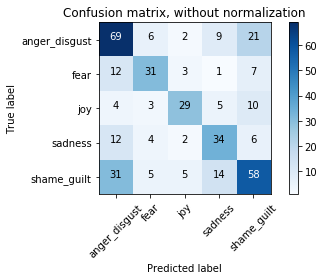

In [233]:
class_names = ['anger_disgust', 'fear', 'joy','sadness', 'shame_guilt']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.64 0.06 0.02 0.08 0.2 ]
 [0.22 0.57 0.06 0.02 0.13]
 [0.08 0.06 0.57 0.1  0.2 ]
 [0.21 0.07 0.03 0.59 0.1 ]
 [0.27 0.04 0.04 0.12 0.51]]


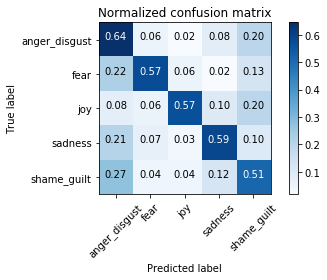

In [234]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [236]:
post_seq = tokenizer.texts_to_sequences(["I feel good", "Headache of the century coming- I can feel it  Fuck.", "I hapened to overhear something which I was not meant to hear"])
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)
p = model.predict(post_seq_padded)
p = np.argmax(p, axis=1)
p

array([2, 3, 4])